In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import ticker
import scipy.signal as sig

In [2]:
filename = './Cutter/2024_10_30_1351_RISE_02_sub_rec_1'

# filter options

reverse_xy = False
    
linear_baseline_correction = True

filter = True

low_freq = 0.1

high_freq = 20

filter_order = 4

In [3]:
df = pd.read_csv(os.path.join(filename+'.txt'), sep='\t')
df = df.iloc[:, -4:]

# time domain

rec_t_sec = df.iloc[:, 0].values

rec_a = df.iloc[:, 1:4].values

In [4]:
sps = len(rec_t_sec) / (rec_t_sec[-1] - rec_t_sec[0])

# reverse axes

if reverse_xy:
    rec_a[:, 0] = -rec_a[:, 0]
    rec_a[:, 1] = -rec_a[:, 1] 
    
# remove mean (zero-order correction)

rec_a_cor = rec_a - np.mean(rec_a, axis=0)

# linear baseline correction

if linear_baseline_correction:
    
    rec_a_cor = np.empty_like(rec_a)
    
    for i in range(3):
        
        signal = rec_a[:, i]
        mean_signal = np.mean(signal)
        mean_time = np.mean(rec_t_sec)

        numerator = np.sum((rec_t_sec - mean_time) * (signal - mean_signal))
        denominator = np.sum((rec_t_sec - mean_time) ** 2)
        slope = numerator / denominator
        intercept = mean_signal - slope * mean_time
        baseline = slope * rec_t_sec + intercept

        rec_a_cor[:, i] = signal - baseline
        
# bandpass filter

if filter:

    b, a = sig.butter(filter_order, [low_freq, high_freq], btype='band', fs = sps)

    rec_a_filt = np.apply_along_axis(lambda axis: sig.filtfilt(b, a, axis), axis=0, arr=rec_a_cor)

In [5]:
# frequency domain

if np.size(rec_a_cor[:, 0]) % 2 == 1:
    rec_t_sec = rec_t_sec[:-1]
    rec_a_cor = rec_a_cor[:-1, :] 

N = np.size(rec_t_sec)
f = np.linspace(0, sps/2, N//2 + 1)

fft_a_cor = np.fft.fft(rec_a_cor, axis=0)

amp_cor = np.abs(fft_a_cor[0:N//2 + 1, :]) / N
amp_cor[1:-1, :] = 2 * amp_cor[1:-1, :]

PSD_cor = np.abs(fft_a_cor[0:N//2 + 1])**2 / (N*sps)
PSD_cor[1:-1] = 2 * PSD_cor[1:-1]
                                  

if filter:
    
    if np.size(rec_a_filt[:, 0]) % 2 == 1:
        rec_a_filt = rec_a_filt[:-1, :] 

    N = np.size(rec_t_sec)
    f = np.linspace(0, sps/2, N//2 + 1)
    
    fft_a_filt = np.fft.fft(rec_a_filt, axis=0)
    
    amp_filt = np.abs(fft_a_filt[0:N//2 + 1, :]) / N
    amp_filt[1:-1, :] = 2 * amp_filt[1:-1, :]

    PSD_filt = np.abs(fft_a_filt[0:N//2 + 1])**2 / (N*sps)
    PSD_filt[1:-1] = 2 * PSD_filt[1:-1]

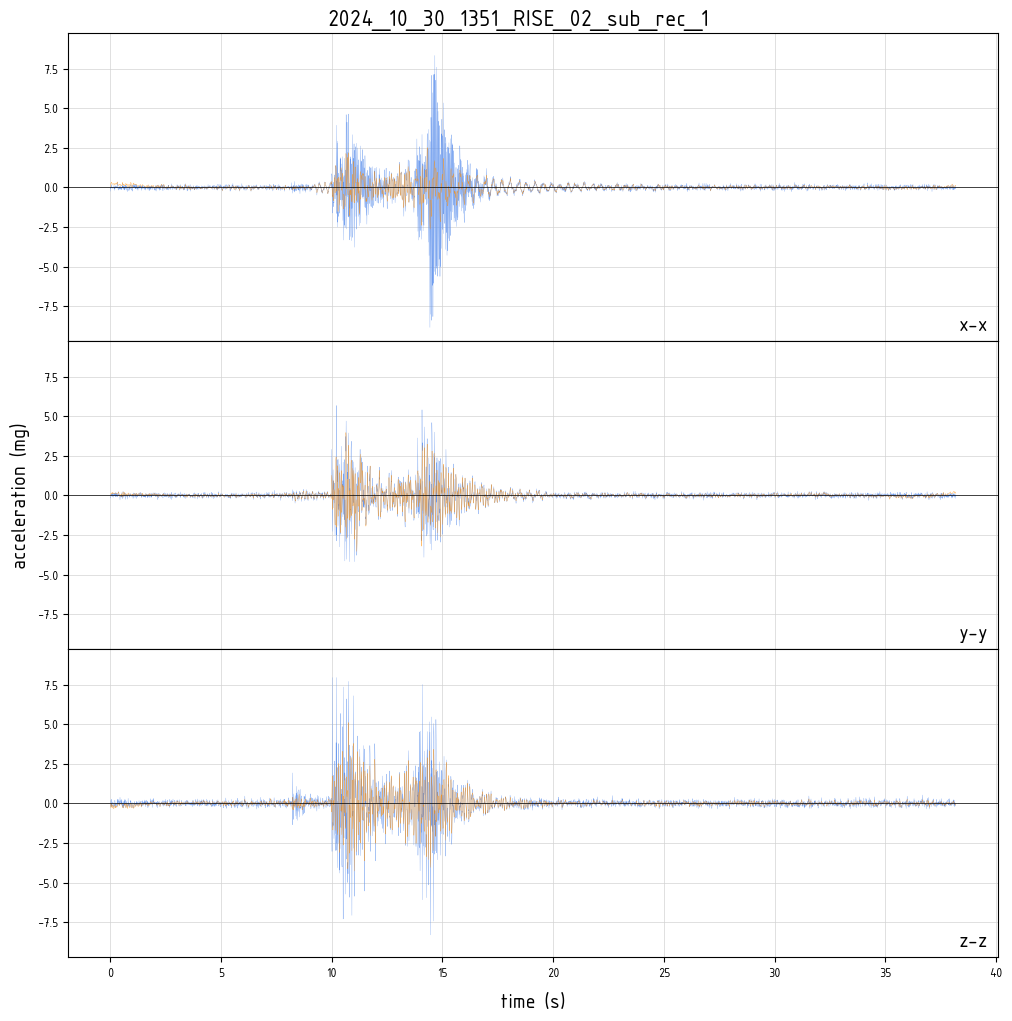

In [6]:
# time domain plot

rcParams['font.family'] = 'isocpeur'

axisLabels = ['x-x', 'y-y', 'z-z']

fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

fig.suptitle(f"{filename.rsplit('/', 3)[-1]}", fontsize=18, y=0.9)

amax = 1.1 * max([np.max(np.abs(acc)) for acc in rec_a_cor])
    
for i, axis in enumerate(axisLabels):

    ax = axs[i]
    ax.grid(color='lightgray', linewidth=0.5)
    ax.set_title(f'{axis}', fontsize=16, x = 0.99, y=0.01, ha='right')
    ax.tick_params(axis='x', labelsize=10, rotation=0)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_ylim(-amax, amax)

    ax.plot(rec_t_sec, rec_a_cor[:,i], linewidth=0.2, color='cornflowerblue', alpha=1.0)

    if filter:
        ax.plot(rec_t_sec, rec_a_filt[:,i], linewidth=0.2, color='darkorange', alpha=1.0)

    ax.axhline(0, color='black', linewidth=0.5)

    if i < 2:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

axs[1].set_ylabel('acceleration (mg)', fontsize=16, labelpad=5)
axs[2].set_xlabel('time (s)', fontsize=16, labelpad=10)
plt.subplots_adjust(hspace=0)

plt.savefig(filename+'.png', bbox_inches = 'tight', dpi = 300, transparent = True)
plt.show()
plt.close()

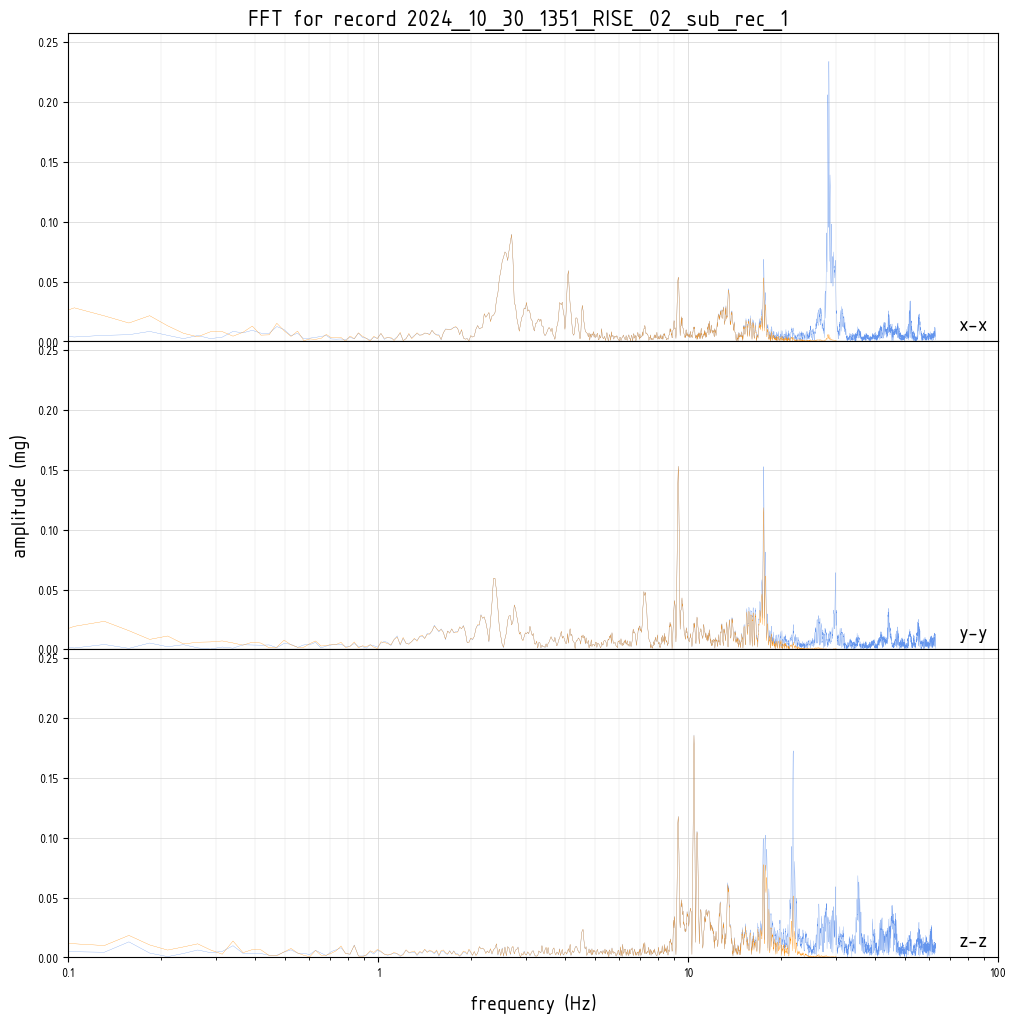

In [7]:
# FFT plot

rcParams['font.family'] = 'isocpeur'

axisLabels = ['x-x', 'y-y', 'z-z']

cmap = plt.get_cmap('tab20')

fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

fig.suptitle(f"FFT for record {filename.rsplit('/', 3)[-1]}", fontsize=18, y=0.9)

amp_max = 1.1 * max([np.max(np.abs(acc)) for acc in amp_cor])

for i, axis in enumerate(axisLabels):

    ax = axs[i]
    ax.grid(color='lightgray', linewidth=0.5)
    ax.grid(which='minor', color='lightgray', linewidth=0.2)
    ax.set_title(f'{axis}', fontsize=16, x = 0.99, y=0.01, ha='right')
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xscale('log')
    ax.set_xlim([0.1,100])
    ax.set_ylim(0, amp_max)
    
    ax.plot(f, amp_cor[:,i], linewidth=0.2, color='cornflowerblue', alpha=1.0)

    if filter:
        ax.plot(f, amp_filt[:,i], linewidth=0.2, color='darkorange', alpha=1.0)

    ax.axhline(0, color='black', linewidth=0.5)

    if i < 2:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

axs[1].set_ylabel('amplitude (mg)', fontsize=16, labelpad=5)
axs[2].set_xlabel('frequency (Hz)', fontsize=16, labelpad=10)
plt.subplots_adjust(hspace=0)

plt.savefig(filename+'_fft.png', bbox_inches = 'tight', dpi = 300, transparent = True)
plt.show()
plt.close()

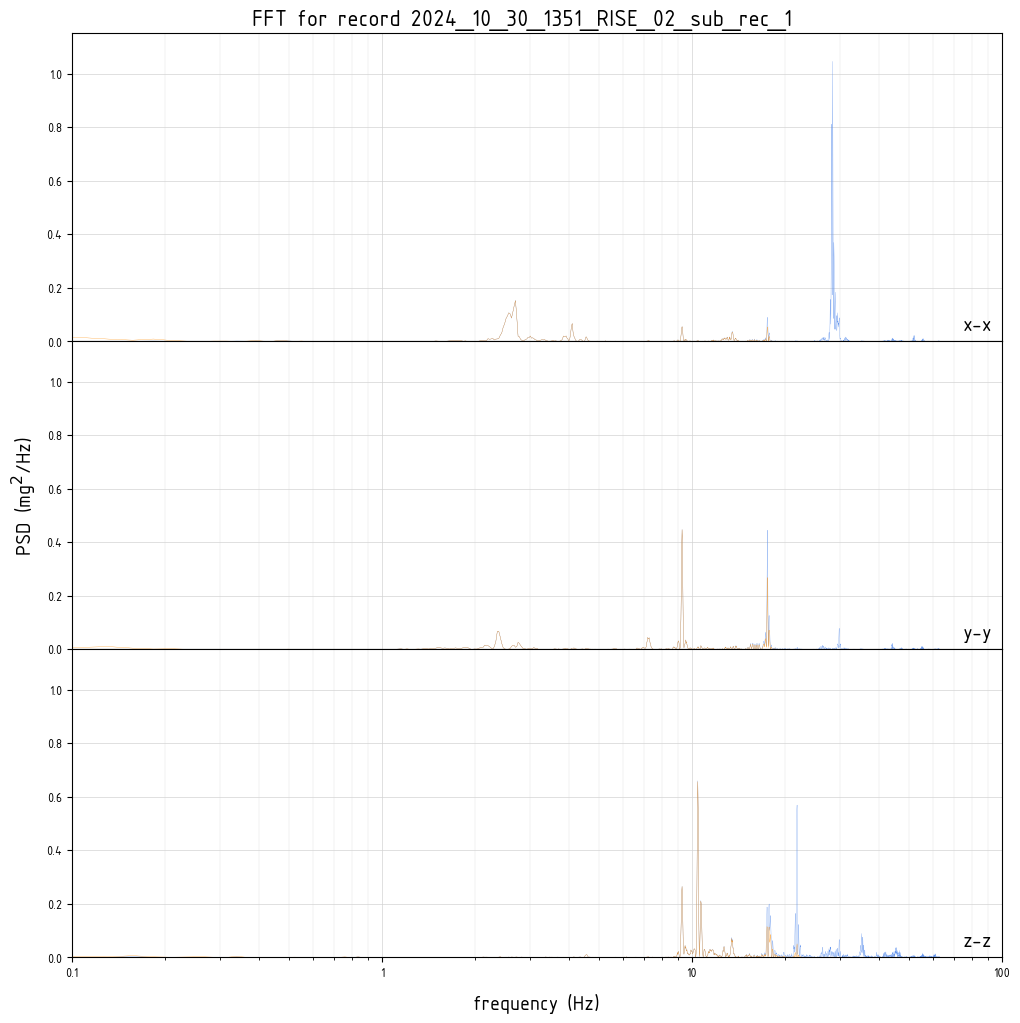

In [8]:
# PSD plot

rcParams['font.family'] = 'isocpeur'

axisLabels = ['x-x', 'y-y', 'z-z']

cmap = plt.get_cmap('tab20')

fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

fig.suptitle(f"FFT for record {filename.rsplit('/', 3)[-1]}", fontsize=18, y=0.9)

PSD_max = 1.1 * max([np.max(np.abs(acc)) for acc in PSD_cor])

for i, axis in enumerate(axisLabels):

    ax = axs[i]
    ax.grid(color='lightgray', linewidth=0.5)
    ax.grid(which='minor', color='lightgray', linewidth=0.2)
    ax.set_title(f'{axis}', fontsize=16, x = 0.99, y=0.01, ha='right')
    ax.tick_params(axis='y', labelsize=10)
    ax.set_xscale('log')
    ax.set_xlim([0.1,100])
    ax.set_ylim(0, PSD_max)
    
    ax.plot(f, PSD_cor[:,i], linewidth=0.2, color='cornflowerblue', alpha=1.0)

    if filter:
        ax.plot(f, PSD_filt[:,i], linewidth=0.2, color='darkorange', alpha=1.0)

    ax.axhline(0, color='black', linewidth=0.5)

    if i < 2:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%g'))

axs[1].set_ylabel('PSD (mg$^{2}$/Hz)', fontsize=16, labelpad=5)
axs[2].set_xlabel('frequency (Hz)', fontsize=16, labelpad=10)
plt.subplots_adjust(hspace=0)

plt.savefig(filename+'_psd.png', bbox_inches = 'tight', dpi = 300, transparent = True)
plt.show()
plt.close()